### Objective
Data - Tourism data with tourist spot name, category, latitude and longitude
- Get distance between each pair of tourist spot using coordinates in KM.
- Plot a directed graph to represent/visualize the distance from a tourist spot/point to all other spots.
- Assume we have tourist spots coordinates within a city, How can we cover all the spots by travelling minimal distance possible.
    - Use Travelling Sales Man Problem approach.
    - Visualize the shortest path and calculate the shortest distance in KM.

In [1]:
!nvidia-smi

Wed Jan 29 16:28:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 567, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 567 (delta 188), reused 144 (delta 100), pack-reused 269 (from 1)
Receiving objects: 100% (567/567), 183.25 KiB | 13.09 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Using Python 3.11.11 environment at /usr
Resolved 2 packages in 65ms
Prepared 2 packages in 7ms
Installed 2 packages in 1ms
 + nvidia-ml-py==12.570.86
 + pynvml==12.0.0
Installing RAPIDS remaining 24.10.* libraries
Using Python 3.11.11 environment at /usr
Resolved 152 packages in 10.42s
Prepared 30 packages in 55.88s
Uninstalled 3 packages in 42ms
Installed 30 packages in 98ms
 + cucim-cu12==24.10.0
 + cugraph-cu12==24.10.0
 + cuml-cu12==24.10.0
 + cuproj-cu12==24.10.0
 + cuspatial-cu12==24.10.0
 + cuvs-cu12==24.10.0
 + cuxfilter-cu12==24.10.0
 - dask==2024.10.0
 + dask==2024.9.0
 + dask-cuda==24.10.0
 + dask-cudf-cu12==24.10.1
 

In [3]:
import cugraph
cugraph.__version__

'24.10.00'

In [4]:
NX_CUGRAPH_AUTOCONFIG=True #enable nx-cugraph

In [6]:
import pandas as pd
df=pd.read_csv('/Address.csv')
df

,Name,Category,Latitude,Longitude
0,Empire State Building,Landmark,40.748817,-73.985428
1,Statue of Liberty,Landmark,40.689247,-74.044502
2,Central Park,Park,40.785091,-73.968285
3,Times Square,Landmark,40.758000,-73.985500
4,Brooklyn Bridge,Landmark,40.706100,-73.996900


In [7]:
import math

def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance

In [8]:
# Extract the first row
pp0,pp1=df.iloc[0,-2:]

# Compute distance from the pp to all other delivery point
df['dist_km'] = df.apply(lambda row: haversine(pp0,pp1,row['Latitude'],row['Longitude']),axis=1)

In [9]:
df

,Name,Category,Latitude,Longitude,dist_km
0,Empire State Building,Landmark,40.748817,-73.985428,0.000000
1,Statue of Liberty,Landmark,40.689247,-74.044502,8.286243
2,Central Park,Park,40.785091,-73.968285,4.284076
3,Times Square,Landmark,40.758000,-73.985500,1.021121
4,Brooklyn Bridge,Landmark,40.706100,-73.996900,4.847286


In [10]:
# from geopy.distance import geodesic
# distance = geodesic((40.748817,-73.985428), (40.785091,-73.968285)).kilometers
# distance

In [11]:
# !pip install graphlet
#!pip install matplotlib

In [12]:
#import graphlet as gt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [14]:
%%time
# Create a graph
G = nx.DiGraph()

# Add nodes for each place
for index, row in df.iterrows():
    G.add_node(row['Name'], lat=row['Latitude'], lon=row['Longitude'])

# Add edges between the first place (Place A) and all other places based on the distance
for index, row in df.iterrows():
    if row['Name'] != 'Empire State Building':
        G.add_edge('Empire State Building', row['Name'], weight=round(row['dist_km'],2))

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.83 ms


In [15]:
G.nodes['Empire State Building']

{'lat': 40.748817, 'lon': -73.985428}

In [16]:

# Create a layout for the graph
layout = {}
for node in G.nodes:
    lat = G.nodes[node]['lat']
    lon = G.nodes[node]['lon']
    layout[node] = (lon, lat)
# Use longitude and latitude as the x and y coordinates

In [17]:
layout

{'Empire State Building': (-73.985428, 40.748817),
 'Statue of Liberty': (-74.044502, 40.689247),
 'Central Park': (-73.968285, 40.785091),
 'Times Square': (-73.9855, 40.758),
 'Brooklyn Bridge': (-73.9969, 40.7061)}

In [18]:
# Get edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')

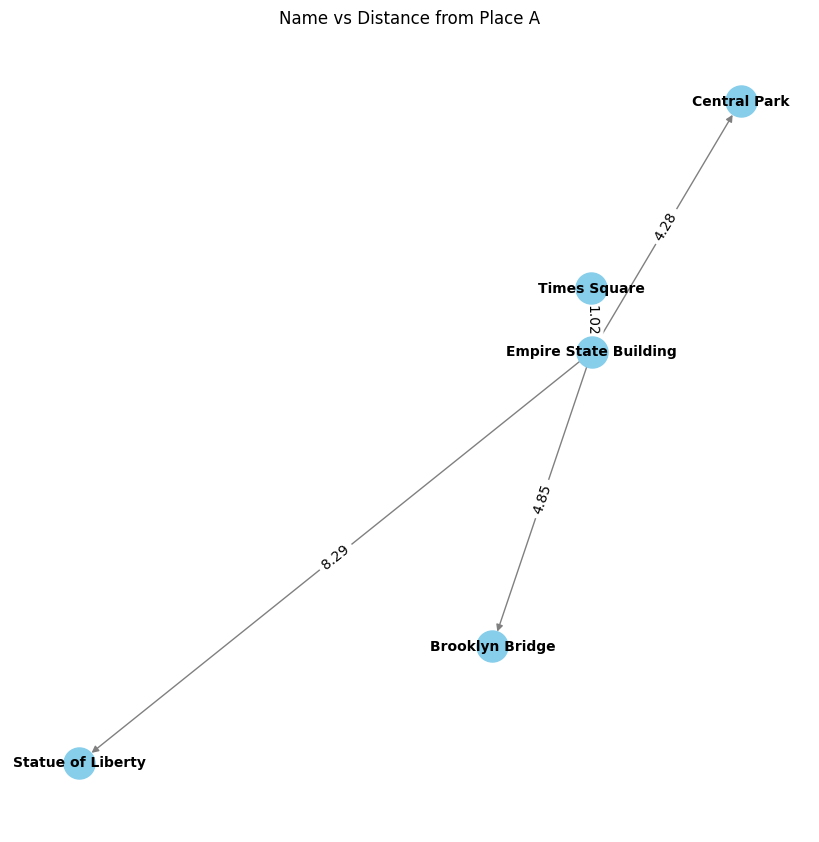

In [19]:
# Draw the graph
plt.figure(figsize=(8, 8))
pos = layout
#pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Name vs Distance from Place A')
plt.show()


In [ ]:
# # Adjust edge width based on distance
# edge_widths = [G[u][v]['weight'] for u, v in G.edges]
# nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', font_size=12, font_weight='bold',
#         edge_color=edge_widths, width=2, cmap=plt.cm.Blues)


In [20]:
%%time
distances = pd.DataFrame(index=df.index, columns=df.index)
for i in df.index:
    for j in df.index:
        if i != j:
            distances.loc[i, j] = haversine(df.loc[i, "Latitude"],df.loc[i, "Longitude"], df.loc[j, "Latitude"], df.loc[j, "Longitude"])

CPU times: user 3.92 ms, sys: 0 ns, total: 3.92 ms
Wall time: 3.93 ms


In [21]:
distances.index=df.Name
distances.columns=df.Name
distances.fillna(0,inplace=True)

<ipython-input-21-52eb30a09540>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  distances.fillna(0,inplace=True)


In [22]:
from networkx.algorithms.approximation import traveling_salesman_problem

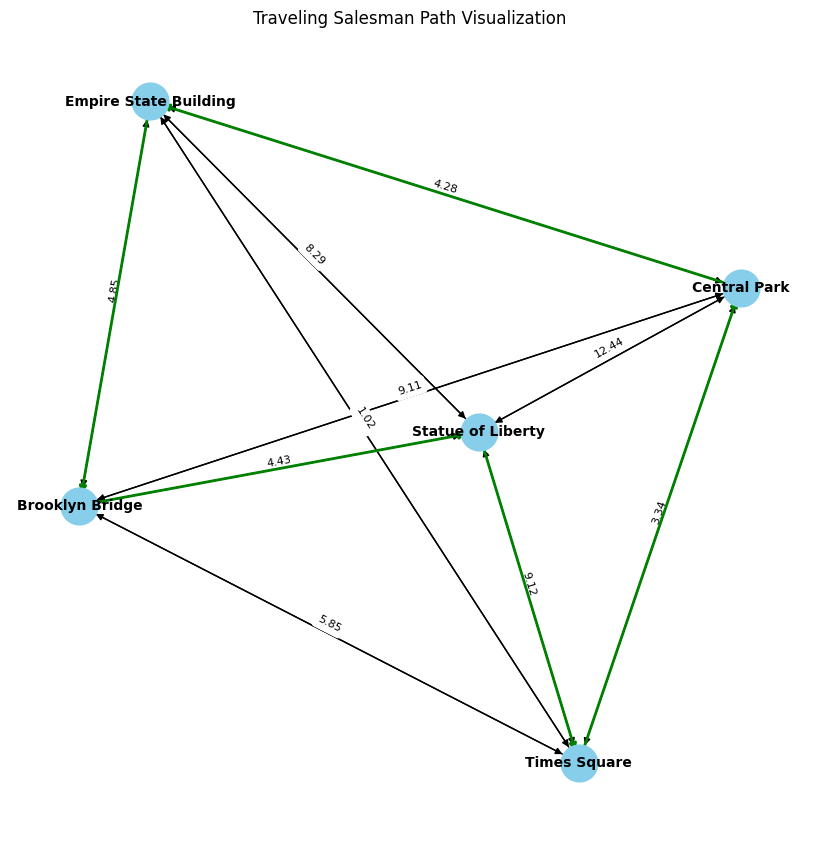

CPU times: user 1.51 s, sys: 411 ms, total: 1.93 s
Wall time: 1.64 s


In [23]:
#Distance matrix to graph
%%time
G= nx.DiGraph()
distance_matrix=distances
for i in distance_matrix.index:
    for j in distance_matrix.columns:
        if i != j:  # Exclude self-loops
            G.add_edge(i, j, weight=round(distance_matrix.loc[i, j],2))

# Find an approximate Traveling Salesman Path
tsp_path = traveling_salesman_problem(G, cycle=True, weight='weight')

plt.figure(figsize=(8, 8))
# Visualize the TSP path
pos = nx.spring_layout(G)  # Layout for positioning nodes

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=700, font_size=10,font_weight="bold")
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8,verticalalignment="bottom")

# Highlight the TSP path
tsp_edges = list(zip(tsp_path, tsp_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=tsp_edges, edge_color="green", width=2)
# Highlight TSP nodes in a different color
# Show the plot
plt.title("Traveling Salesman Path Visualization")
plt.show()

In [24]:
# Find Shortest Path using TSP approach
%%time
tsp_path = traveling_salesman_problem(G, cycle=True, weight='weight')
tsp_length = sum(G[u][v]['weight'] for u, v in zip(tsp_path, tsp_path[1:]))

CPU times: user 433 ms, sys: 4.63 ms, total: 438 ms
Wall time: 436 ms


In [25]:
print(f"TSP Path Length: {tsp_length:.2f} km")

TSP Path Length: 26.02 km


In [26]:
tsp_path

['Statue of Liberty',
 'Brooklyn Bridge',
 'Empire State Building',
 'Central Park',
 'Times Square',
 'Statue of Liberty']

In [27]:
import simplekml

In [28]:
# Create KML object
kml = simplekml.Kml()

# Add placemarks for each city
for city in tsp_path[:-1]:  # Avoid duplicating the last point
    lat, lon = layout[city]
    kml.newpoint(name=city, coords=[(lon, lat)])

# Create a linestring for the path
line_coords = [(layout[city][1], layout[city][0]) for city in tsp_path]
linestring = kml.newlinestring(name="TSP Path", coords=line_coords)
linestring.style.linestyle.color = simplekml.Color.red
linestring.style.linestyle.width = 3

# Save the KML file
kml.save("tsp_path.kml")